In [8]:
import numpy as np
import scipy.optimize as sp
import matplotlib.pyplot as plt
import csv

In [9]:
#Reading bond from csv file

data = []

with open("D:\\Uni\\Year 4\\Winter\\APM466\\Assignment 1\\data.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    
    for row in csv_reader:
        row.pop(0)
        row.pop(0)
        row.pop(2)
        row.pop(2)
        row.pop(4)
        row.pop(4)
        
        data.append(row)
        
print(data[0])
data = np.array(data)

['ISIN', 'COUPON', 'ISSUE DATE', 'MATURITY DATE', '01/10/2022', '01/11/2022', '01/12/2022', '01/13/2022', '01/14/2022', '01/17/2022', '01/18/2022', '01/19/2022', '01/20/2022', '01/21/2022']


In [10]:
#To give an idea of the data structure, here are the column headers

print(data[0])

['ISIN' 'COUPON' 'ISSUE DATE' 'MATURITY DATE' '01/10/2022' '01/11/2022'
 '01/12/2022' '01/13/2022' '01/14/2022' '01/17/2022' '01/18/2022'
 '01/19/2022' '01/20/2022' '01/21/2022']


In [15]:
#Creating a function to calculate the yield (YTM) given a bond, assuming a par value of $100. Note that 2 of the bonds have
#maturity month of August. This will be approximated as September

def months_till_maturity(maturity_date, current_date):
    """
    Returns the number of months until bond maturity.
    
    ARGUMENTS:

    maturity_date (str): The maturity date of the bond in the format 'M/D/Y'
    current_date (str): The current date in the format 'M/D/Y'
    
    """
    current_date_split = current_date.split('/')
    current_year = int(current_date_split[2])
    current_month = int(current_date_split[0])
    current_day = int(current_date_split[1])
    
    maturity_date_split = maturity_date.split('/')
    maturity_year = int(maturity_date_split[2])
    maturity_month = int(maturity_date_split[0])
    maturity_day = int(maturity_date_split[1])
    
    year_difference = maturity_year - current_year
    month_difference = maturity_month - current_month
    day_difference = maturity_day - current_day
    
    months_till_mat = 12*year_difference + month_difference + day_difference/31
        
    return months_till_mat

def dirty_price(bond_price, coupon, maturity_date, current_date):
    """
    Returns the dirty_price of the bond.
    
    ARGUMENTS:
    
    bond_price (str): The current price of the bond in dollars (eg: '101.23')
    coupon (str): The annual coupon price as a percentage (with the percentage % in the str) of the par value (eg: '1.5%')
    maturity_date (str): The maturity date of the bond in the format 'M/D/Y'
    current_date (str): The current date in the format 'M/D/Y'
    """
    
    months_till_mat = months_till_maturity(maturity_date, current_date)
    months_from_last_payment = 6 - months_till_mat%6
    days_from_last_payment = months_from_last_payment*31
    accrued_interest = days_from_last_payment/365 * float(coupon[:-1])
    
    return float(bond_price) + accrued_interest
    
def present_value_YTM(YTM, coupon, maturity_date, current_date):
    """
    Returns the present value of a bond for a given interest rate (YTM), with continuous compounding.
    
    ARGUMENTS:
    
    YTM (float): The YTM of the bond as a percentage (eg: 1.2)
    coupon (str): The annual coupon price as a percentage (with the percentage % in the str) of the par value (eg: '1.5%')
    maturity_date (str): The maturity date of the bond in the format 'M/D/Y'
    current_date (str): The current date in the format 'M/D/Y'
    
    """
    
    time = months_till_maturity(maturity_date, current_date)
    real_YTM = YTM/100
    real_coupon = float(coupon[:-1])/2
    
    present_value = (100 + real_coupon)*np.exp(-real_YTM * time/12)
    time += -6
    
    while time > 0:
        present_value += real_coupon*np.exp(-real_YTM * time/12)
        time += -6
    
    return present_value
                      
    
def YTM(bond_price, coupon, maturity_date, current_date):
    """
    Returns the YTM of a given bond with semiannual payments in March and September.
    
    ARGUMENTS:
    
    bond_price (str): The current price of the bond in dollars (eg: '101.23')
    coupon (str): The annual coupon price as a percentage (with the percentage % in the str) of the par value (eg: '1.5%')
    maturity_date (str): The maturity date of the bond in the format 'M/D/Y'
    current_date (str): The current date in the format 'M/D/Y'
    
    """
    dirty = dirty_price(bond_price, coupon, maturity_date, current_date)
    
    def function_to_solve(YTM):
        return present_value_YTM(YTM, coupon, maturity_date, current_date) - dirty
    
    YTM = sp.newton(function_to_solve, x0 = 1)
    
    return YTM

In [17]:
#Focussing on just the 10 selected bonds

selected_bonds = data[[3, 9, 4, 14, 5, 6, 26, 27, 29, 30], :]

In [18]:
#Computing the Yield curve

yields = []
for i in range(4, 14):
    ytms = []
    for bond in selected_bonds:
        ytm = YTM(bond[i], bond[1], bond[3], data[0][i])
        ytms.append(ytm)
    yields.append(ytms)
    
time_till_mat = []
for bond in selected_bonds:
    time = months_till_maturity(bond[3], data[0][4])
    time_till_mat.append(time)
    
years_till_mat = np.array(time_till_mat)/12
yields = np.array(yields)

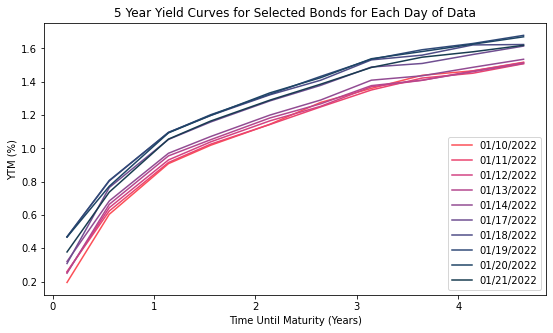

In [19]:
#Plotting the yield curve

colours = ['#fc4f57', '#eb446f', '#d24382', '#b4478e', '#924c93', '#6f4e91', '#4e4d87', '#314a78', '#1e4465', '#183c50']

plt.figure(0, figsize = (9, 5))
    
for i in range(len(yields)):
    plt.plot(years_till_mat, yields[i], color = colours[i], label = data[0][i+4])

plt.xlabel('Time Until Maturity (Years)')
plt.ylabel('YTM (%)')
plt.title('5 Year Yield Curves for Selected Bonds for Each Day of Data')
plt.legend()

In [20]:
#We now create the spot curve

def spot(bond_prices, coupons, maturity_dates, current_date):
    
    """
    Returns the spot curve for a given day.
    
    ARGUMENTS:
    
    bond_prices list[str]: The current prices of the bonds in dollars (eg: '101.23')
    coupons list[str]: The annual coupon prices as a percentage (with the percentage % in the str) of the par value (eg: '1.5%')
    maturity_dates list[str]: The maturity dates of the bonds in the format 'M/D/Y'
    current_date (str): The current date in the format 'M/D/Y'
    
    """
    
    real_coupons = []
    for coupon in coupons:
        real_coupons.append(float(coupon[:-1])/2)
        
    real_coupons = np.array(real_coupons)
    
    real_bonds = []
    for i in range(len(bond_prices)):
        real_bonds.append(dirty_price(bond_prices[i], coupons[i], maturity_dates[i], current_date))
        
    real_bonds = np.array(real_bonds)

    #We compute the first yield value manually
    
    time_0 = months_till_maturity(maturity_dates[0], current_date)/12
    spot_0 = -np.log(real_bonds[0]/(real_coupons[0] + 100))/time_0
    
    spots = [spot_0]
    times = [time_0]
    
    #and now iterate to implement the bootstrapping procedure
    for i in range(1, len(real_bonds)):
        time = months_till_maturity(maturity_dates[i], current_date)/12
        
        summation = 0
        for j in range(len(spots)):
            summation += real_coupons[i] * np.exp(-spots[j] * times[j])
            
        to_log = (real_bonds[i] - summation)/(100 + real_coupons[i])
        spot = -1/time * np.log(to_log)
        
        spots.append(spot)
        times.append(time)
    
    return np.array(spots)*100 

In [21]:
spots = []
for i in range(4, 14):
    spotty = spot(selected_bonds[:,i], selected_bonds[:,1], selected_bonds[:,3], data[0][i])
    spots.append(spotty)

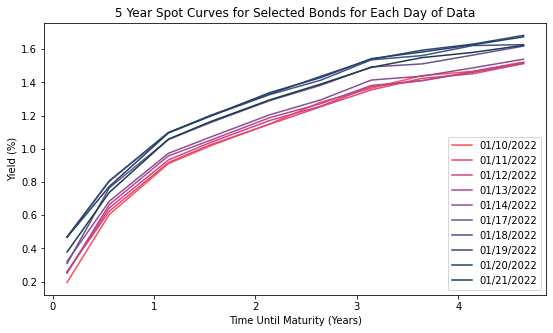

In [22]:
plt.figure(1, figsize = (9, 5))
for i in range(len(yields)):
    plt.plot(years_till_mat, spots[i], color = colours[i],  label = data[0][i+4])

plt.xlabel('Time Until Maturity (Years)')
plt.ylabel('Yield (%)')
plt.title('5 Year Spot Curves for Selected Bonds for Each Day of Data')
plt.legend()
plt.savefig('D:\\Uni\\Year 4\\Winter\\APM466\\Assignment 1\\Figure2', dpi = 500)

In [33]:
#Finally, the forward curves

def forward(bond_prices, coupons, maturity_dates, current_date):
    
    """
    Returns the 1-1, 1-2, 1-3 and 1-4 year forward rate for a specific day
    
    ARGUMENTS:
    
    bond_prices list[str]: The current prices of the bonds in dollars (eg: '101.23')
    coupons list[str]: The annual coupon prices as a percentage (with the percentage % in the str) of the par value (eg: '1.5%')
    maturity_dates list[str]: The maturity dates of the bonds in the format 'M/D/Y'
    current_date (str): The current date in the format 'M/D/Y'
    """
    
    forward_yields = []
    spots = spot(bond_prices, coupons, maturity_dates, current_date)
    
    #First the 1 year - 1 year rate
    
    left_derivative = (spots[2]-spots[1])/(1/2)
    right_derivative = (spots[3]-spots[2])/(1/2)
    derivative = (left_derivative + right_derivative)/2
    
    forward_yields.append(derivative + spots[2])
    
    #Now the 1 year - i year rate for i = 2, 3, 4
    
    for i in range(2, 5):
        spot_1 = spots[2]
        spot_2 = spots[2*i]
        
        forward_yield = (spot_2*(i) - spot_1)/(i - 1)
        forward_yields.append(forward_yield)
        
    return forward_yields

In [34]:
forward_yields = []
for i in range(4, 14):
    forwards = forward(selected_bonds[:,i], selected_bonds[:,1], selected_bonds[:,3], data[0][i])
    forward_yields.append(forwards)

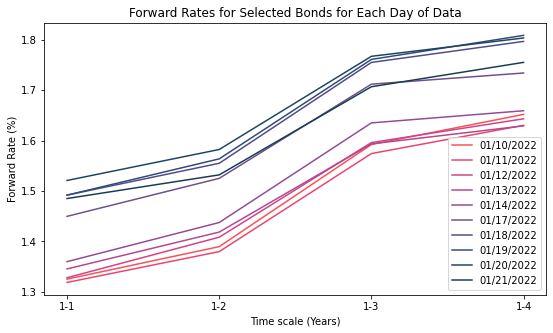

In [35]:
plt.figure(2, figsize = (9, 5))

x_axis = np.array(['1-1', '1-2', '1-3', '1-4'])

for i in range(len(yields)):
    plt.plot(x_axis, forward_yields[i], color = colours[i], label = data[0][i+4])

plt.xlabel('Time scale (Years)')
plt.ylabel('Forward Rate (%)')
plt.title('Forward Rates for Selected Bonds for Each Day of Data')
plt.legend()


In [36]:
#making the data matrix of log returns

data_matrix = []

#We want the rows to be the random variables, and the columns to be the observations
yield_data_matrix = np.transpose(yields)

#And we only care about the yield every year for this question, not every 6 months
yield_data_matrix = yield_data_matrix[[1, 3, 5, 7, 9], :]

for year_data in  yield_data_matrix:
    
    random_variable = []
    for i in range(len(year_data) - 1):
        log_return = np.log(year_data[i + 1]/year_data[i])
        random_variable.append(log_return)

    data_matrix.append(random_variable)
    
#And now doing the same for the forward rate
    
data_matrix2 = []

#We want the rows to be the random variables, and the columns to be the observations
forward_data_matrix = np.transpose(forward_yields)

for year_data in  forward_data_matrix:
    
    random_variable = []
    for i in range(len(year_data) - 1):
        log_return = np.log(year_data[i + 1]/year_data[i])
        random_variable.append(log_return)

    data_matrix2.append(random_variable)

In [38]:
#Computing the covariance matrices:

yield_covariance_matrix = np.cov(data_matrix)
forward_covariance_matrix = np.cov(data_matrix2)

[1.65171967 1.63011891 1.64303046 1.6290286  1.65897543 1.73371082
 1.79627103 1.80829355 1.80308994 1.75477226]
[-0.013164006507359546, 0.007889412627356847, -0.008558494134301698, 0.018216319861364853, 0.044063890649874905, 0.035448769607621534, 0.006670744402143971, -0.002881779658838587, -0.027162745562154037]


In [39]:
#And printing the covariance matrices:

print(yield_covariance_matrix)
print(forward_covariance_matrix)

[[0.00232539 0.00131447 0.00106866 0.00086667 0.00082452]
 [0.00131447 0.00084979 0.00073983 0.00059966 0.00055758]
 [0.00106866 0.00073983 0.00075946 0.00061292 0.00058317]
 [0.00086667 0.00059966 0.00061292 0.00056471 0.00048955]
 [0.00082452 0.00055758 0.00058317 0.00048955 0.00056561]]
[[0.00059562 0.00056373 0.00050815 0.00048251]
 [0.00056373 0.00058999 0.00053898 0.00049382]
 [0.00050815 0.00053898 0.00054954 0.00051631]
 [0.00048251 0.00049382 0.00051631 0.00052781]]


In [40]:
#Computing the eigenvectors and eigenvalues for the principal component analysis:

yield_eig = np.linalg.eig(yield_covariance_matrix)
forward_eig = np.linalg.eig(forward_covariance_matrix)

In [41]:
#Printing the eigenvectors:

print(yield_eig[1])
print(forward_eig[1])

[[-0.69230315  0.63642814  0.17961391 -0.21128601 -0.19690766]
 [-0.42702022  0.00832735 -0.34919648  0.68797341  0.47152815]
 [-0.38293506 -0.42764986 -0.2981342  -0.65338843  0.39328857]
 [-0.3161594  -0.43185831 -0.33136545  0.1616894  -0.75999679]
 [-0.30294233 -0.47487248  0.80443371  0.17026716  0.08134843]]
[[ 0.50806873  0.61619122  0.53321358 -0.27903014]
 [ 0.5166144   0.31899073 -0.5726037   0.55088972]
 [ 0.49839225 -0.36716301 -0.40325599 -0.67392959]
 [ 0.47600513 -0.61947125  0.47454493  0.40556331]]


In [42]:
#Printing the eigenvalues:

print(yield_eig[0])
print(forward_eig[0])

[4.48387232e-03 4.21190323e-04 8.98786115e-05 2.23931370e-05
 4.76209589e-05]
[2.11935705e-03 9.95952323e-05 3.53633967e-05 8.64538155e-06]
